In [2]:
#Bibliotecas utilizadas
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

1) Implement a function that performs global and local histogram equalization of an image and test it on images flower_bee and fig3.15(a). Discuss the results by evaluating the histograms. Calculate the sample mean and sample variance of the images, before and after equalization. Show, for each case, the histogram before and after applying the methods. Is it possible to relate the results to the images? Explain.

In [32]:
#Transforma a imagem para tons de cinza:
def convert_tons_cinza (img):
  dimensoes = img.shape
  if dimensoes[2] == 3:
    img_cinza = np.zeros((dimensoes[0], dimensoes[1]), dtype=np.uint8)
    for i in range (dimensoes[0]):
      for j in range (dimensoes[1]):
        b, g, r = img[i, j]
        img_cinza[i, j] = int(0.114*b + 0.587*g + 0.299*r)
    return img_cinza
  else:
    return img
#Calcula o histograma da imagem:   
def calcula_histograma (image):
  histogram = [0] *256
  for i in range (image.shape[0]):
    for j in range (image.shape[1]):
      intensidade = int(image[i,j])
      histogram [intensidade] = histogram[intensidade] + 1
  return histogram

#Faz a equalização global:
def equalizacao_global (img):
  altura, largura = img.shape
  N = altura*largura
  hist = calcula_histograma(img)
  Norm = [x / N for x in hist]

  cdf=[]
  acumulado = 0

  for pixel in Norm:
    acumulado += pixel
    cdf.append(acumulado)

  mapeia_intensi = [round(255*c) for c in cdf]
  img_equalizada = np.zeros_like(img)
  for i in range (altura):
    for j in range(largura):
      img_equalizada[i,j] = mapeia_intensi[img[i,j]]

  return img_equalizada

#Faz a equalização local:
def equalizacao_local (img, janela = (3,3)):
  altura_janela, largura_janela = janela
  if altura_janela%2 == 0 or largura_janela%2 == 0:
     raise ValueError("A janela implementada nesse metódo exige que os valores sejam ìmpares")
  
  altura,largura =img.shape
  meia_altura_janela = altura_janela // 2
  meia_largura_janela = largura_janela // 2

  #Criando um padding para evitar problemas no processo de extração de informações nas bordas da imagem:
  pad_altura=  altura + 2*meia_altura_janela
  pad_largura = largura + 2*meia_largura_janela
  img_padding = np.zeros((pad_altura,pad_largura), dtype= img.dtype)

  #Coloca  a imgem original no centro da nova imagem com as bordas geradas:
  img_padding[meia_altura_janela:-meia_altura_janela, meia_largura_janela:-meia_largura_janela] =img
  
  #Preenchimento das bordas da imagem:
  img_padding[0:meia_altura_janela, :] = img_padding[meia_altura_janela,:]
  img_padding[-meia_altura_janela:, :] =img_padding[-meia_altura_janela-1,:]
  img_padding[:,0:meia_largura_janela] = img_padding[:,meia_largura_janela].reshape(-1,1)
  img_padding[:, -meia_largura_janela:] = img_padding[:, -meia_largura_janela-1].reshape(-1,1)
  img_final = np.zeros_like(img)

  #Implementando o metodo das janelas deslizantes para varrer a imagem:
  for y in range (altura):
    for x in range (largura):

      area_analisada = img_padding[y : y + altura_janela, x : x + largura_janela]
      histogram_local = calcula_histograma(area_analisada)
      cdf_local = np.cumsum(histogram_local)

      val_central_original = img[y,x]
      cdf_min_local_vals = cdf_local[np.nonzero(cdf_local)]
      if cdf_min_local_vals.size == 0:
            novo_valor = val_central_original
      else:
            cdf_min = cdf_min_local_vals[0]            
            total_pixels_janela = altura_janela * largura_janela   
            denominador = total_pixels_janela - cdf_min
            
            if denominador == 0:
              novo_valor = val_central_original
            
            else:
              
              numerador = cdf_local[val_central_original] - cdf_min
              novo_valor = round((numerador / denominador) * 255)
            
      img_final[y, x] = novo_valor
            
    return img_final
  

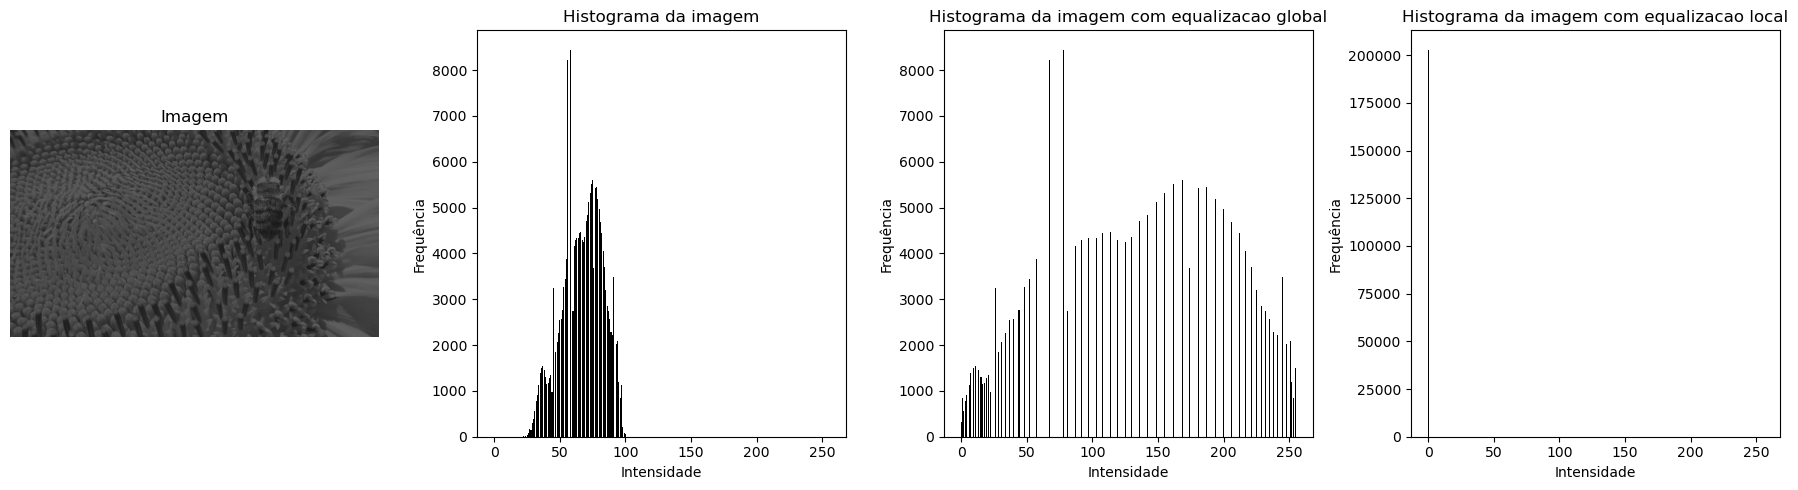

In [33]:
img = cv2.imread("images/flower_bee.png")
img_cinza = convert_tons_cinza(img)
histograma = calcula_histograma(img_cinza)
equaliza_global = equalizacao_global(img_cinza)
histograma_equalizada = calcula_histograma(equaliza_global)
img_local_eq = equalizacao_local(img_cinza, (11,11))
histograma_equalizada2 = calcula_histograma(img_local_eq)
intensidades = list(range(256))
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagem")
axs[0].axis('off')
axs[1].bar(intensidades, histograma, color='black')
axs[1].set_title("Histograma da imagem")
axs[1].set_xlabel("Intensidade")
axs[1].set_ylabel("Frequência")
axs[2].bar(intensidades, histograma_equalizada, color='black')
axs[2].set_title("Histograma da imagem com equalizacao global")
axs[2].set_xlabel("Intensidade")
axs[2].set_ylabel("Frequência")
axs[3].bar(intensidades, histograma_equalizada2, color='black')
axs[3].set_title("Histograma da imagem com equalizacao local")
axs[3].set_xlabel("Intensidade")
axs[3].set_ylabel("Frequência")

plt.tight_layout()
plt.show()

2) Reproduce Example 3.12 of the textbook (3rd edition).

3) Make a routine that implements an NxN (N must be an odd number) spatial
convolution mask. You must discuss possible solutions for padding the borders and
implement one of them. Evaluate the implemented routine on the lena.tif image, for
the following cases: a) Low-Pass Filter, b) Laplacian filter (adding the original
image to the result), c) Sobel filter (pass the two masks and return the image of the
gradient magnitude). Show the obtained images and analyze them.

4) Write a routine that implements in the frequency domain: a) a Butterworth low-pass filter of order n=1 and apply this filter on the image Fig3.35(a).jpg for twovalues of cutoff frequency (D0); b) a Butterworth low-pass filter of order n=8 on the same image and same cutoff frequencies; c) an ideal filter on the same image and same cutoff frequencies. Compare and comment on the results.

5) For the image mar-il.gif, correct the problem of poor illumination in 2 different ways (assume the multiplicative model between reflectance and illumination and discuss the solutions).

6) Reduce the image frexp_1.png by alternately eliminating rows and columns.
Compare the original image with the reduced one. What happened to it? What
procedure could you apply to reduce this effect? Apply the solution devised to
avoid this effect in the reduced image. Compare the new image with the other two
and evaluate the result.

7) Reproduce Example 4.24 of the textbook (3rd edition).

8) Apply to image Fig5.26(a).jpg the blur of Example 5.10 the textbook (3rd edition) and add a Gaussian noise of zero mean and variance of 200. Use the Wiener filtering and inverse filtering to try to recover the image. Calculate the PSNR of the recovered images, present them, and comment on methodologies and results. PSNR (Peak Signal to Noise Ratio) is computed using: where I(i, j) and K(i, j) are the original and corrupted images,respectively, and MAX is the highest gray level value of the original image. Use log10 to calculate PSNR.

9) For the images noise1.jpg and noise2.jpg, apply the filters mean 5x5, median 5x5 and the adaptive median filter (ranging from dimensions 3x3 to dimensions 11x11) to treat the noise. Compare with the original image.jpg by calculating the PSNR. Use log10 to calculate the PSNR. Compare the results and discuss.



##Theoretical questions:


1) Explain with your words the process to obtain a digital image from a continuous
image (consider that (x,y) coordinates and f amplitude are continuous). Make the
considerations regarding spatial and intensity resolution.


2) How would you explain spatial frequency in an image?


3) List and explain the problems related to filtering in the frequency domain and the use of DFT for this purpose. What can be done to reduce/avoid these problems?


4) Explain the optimum notch filtering procedure and in which situations it is interesting to use it.